<a href="https://colab.research.google.com/github/maximdorogov/Practicos_MachineLearning_UNS/blob/main/RxCovid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Download the dataset
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip

--2020-11-01 02:26:56--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.100.128
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.100.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip’

fvk7h5dg2p-1.zip    100%[===================>] 189.77M  22.0MB/s    in 9.6s    

2020-11-01 02:27:07 (19.7 MB/s) - ‘dataroot/fvk7h5dg2p-1.zip’ saved [198985388/198985388]



In [4]:
# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"fvk7h5dg2p-1.zip","r") as zip_ref: zip_ref.extractall(dataroot)

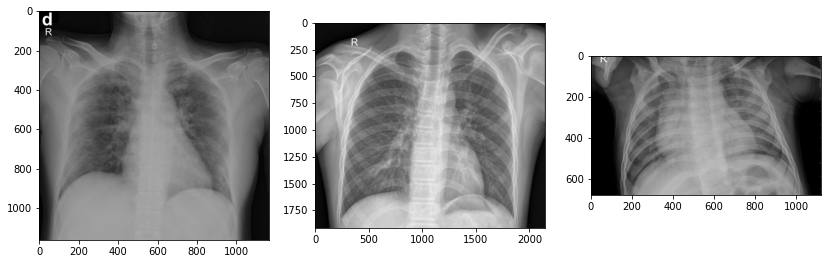

In [5]:
# Load and preview images
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import cv2
import glob

img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal /IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person1650_virus_2854.jpeg',0)



plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')

Functions definition

In [6]:
def extract_hog_features(raw_data, resize_form):

  #mempry allocation
  features = []

  for image in raw_data:
    
    image = cv2.resize(image, resize_form, interpolation=cv2.INTER_AREA)
  #creating hog features 
    feature = hog(image, orientations=9, pixels_per_cell=(8, 8), 
                                   cells_per_block=(2, 2), multichannel=True)
    feature = feature/feature.max()
    features.append(feature)
  return features

Load all images into memory

In [19]:
data = []
target = []
target_tag = np.array([0, 1, 2])
folder_class = ["COVID-19 cases", "Pneumonia", "Normal "]

for i in range(3):

  dir = 0
  for j,dir in enumerate(glob.glob('/content/dataroot/'+folder_class[i]+'/**', recursive=True)):

      data.append(cv2.imread(dir))
      target.append(target_tag[i])
  print(j)

# descarto el 1er elemento porque es None y transformo a np.array()



221
148
234


Delete None elements from the data list and target vector

In [20]:
for j, image in enumerate(data):
  if image is None:
    data.pop(j)
    target.pop(j)

In this work I will use HOG (Histogram Oriented Gradient) feature extraction.

Some papers used as reference for HOG:

http://oa.upm.es/37596/1/INVE_MEM_2014_197870.pdf
http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf

And Support Vector Machines:

http://pyml.sourceforge.net/doc/howto.pdf


Text(0.5, 1.0, 'hog features flattened into a vector')

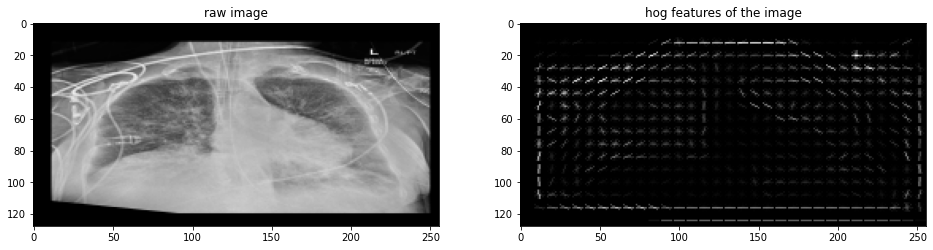

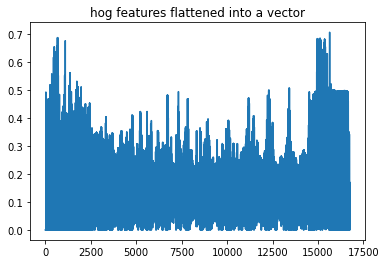

In [21]:
#  HOG features visualization

resize_form = ((256,128)) 
resized_inter = cv2.resize(data[1], resize_form, interpolation=cv2.INTER_AREA)

#creating hog features 
fd, hog_image = hog(resized_inter, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)


plt.figure(figsize=(16,16))
plt.subplot(1,2,1)
plt.imshow(resized_inter, cmap='gray')
plt.title('raw image')

plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('hog features of the image')

plt.figure(4)
plt.plot(fd)
plt.title('hog features flattened into a vector')

Extracting all HOG features

In [22]:
features = extract_hog_features(data, (256,128))

Training a SVM classifier: Default parameters to see the preliminary results. In the next code section I will try to improve this with Cross validation and gridsearch.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [30]:
X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle = True, test_size=0.2, random_state=1)

classifier = svm.SVC(gamma = 0.01)
classifier.fit(X_train, y_train)



SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Evaluation metrics 

validation accuracy: 0.743801652892562
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        46
           1       1.00      0.40      0.57        25
           2       0.81      0.68      0.74        50

    accuracy                           0.74       121
   macro avg       0.83      0.69      0.70       121
weighted avg       0.79      0.74      0.73       121



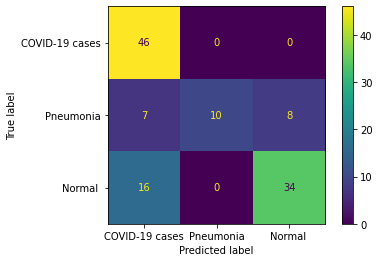

In [31]:
predicted = classifier.predict(X_test)

metrics.plot_confusion_matrix( classifier, X_test, y_test, display_labels = folder_class)
print('validation accuracy:', metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

Hyperparameters optimization: GridSearchCV

In [32]:


# https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

grid_params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

g_search = GridSearchCV(svm.SVC(), grid_params, verbose = 1, cv = 5, n_jobs = -1 )
g_result = g_search.fit(X_train, y_train)


means = g_search.cv_results_['mean_test_score']
stds = g_search.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, g_search.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
  print()


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


0.900 (+/-0.065) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

0.666 (+/-0.031) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}

0.915 (+/-0.052) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

0.907 (+/-0.040) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

0.917 (+/-0.058) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

0.913 (+/-0.049) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

0.917 (+/-0.058) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

0.913 (+/-0.049) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

0.911 (+/-0.047) for {'C': 1, 'kernel': 'linear'}

0.911 (+/-0.047) for {'C': 10, 'kernel': 'linear'}

0.911 (+/-0.047) for {'C': 100, 'kernel': 'linear'}

0.911 (+/-0.047) for {'C': 1000, 'kernel': 'linear'}



Evaluating the best estimator


Best Estimator: 

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

validation accuracy: 0.9338842975206612

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        46
           1       0.88      0.84      0.86        25
           2       0.92      0.92      0.92        50

    accuracy                           0.93       121
   macro avg       0.92      0.92      0.92       121
weighted avg       0.93      0.93      0.93       121



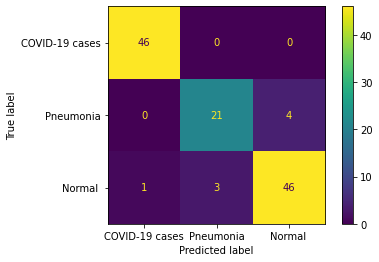

In [18]:
SVM_best = g_result.best_estimator_
predicted = SVM_best.predict(X_test)
validation_acc = metrics.accuracy_score(y_test, predicted)

print("Best Estimator: \n")
print(SVM_best)
print()
print('validation accuracy:', metrics.accuracy_score(y_test, predicted))
print()

metrics.plot_confusion_matrix( SVM_best, X_test, y_test, display_labels = folder_class)

print(classification_report(y_test, predicted))